In [1]:
import pandas as pd
import numpy as np
import re
import os

In [2]:
carpeta_path = r'C:\Users\William\Desktop\el algoritmo es correcto'
archivo_train = r'train_data.csv'
path_train = os.path.join(carpeta_path, archivo_train)

In [3]:
train = pd.read_csv(
    path_train, 
    dtype={
        "tiempodeconstruido": str,
        "vista": str,
        "tipoinmueble": str,
        "tiponegocio": str,
        'valorventa': 'int64',
        # 'area': 'int64'
    }
)
train['data'] = 'train'

In [4]:
train.shape

(244488, 33)

In [5]:
carpeta_path = r'C:\Users\William\Desktop\el algoritmo es correcto'
archivo_test = r'test_data.csv'
path_test = os.path.join(carpeta_path, archivo_test)

In [6]:
test = pd.read_csv(
    path_test, 
    dtype={
        "tiempodeconstruido": str,
        "vista": str,
        "tipoinmueble": str,
        "tiponegocio": str,
        'valorventa': 'int64',
        # 'area': 'int64'
    }
)
test['data'] = 'test'

In [7]:
test.shape

(53, 33)

In [8]:
prueba = pd.concat([train, test], ignore_index=True)

In [9]:
prueba = prueba[
    (prueba['porteria'].isna()) &
    (prueba['conjuntocerrado']==0) &
    (prueba['tipoinmueble']=='Casa') &
    (prueba['ascensor'].isna()) &
    ((prueba['gimnasio'].isna()) | (prueba['gimnasio']==0)) &
    (prueba['piscina'].isna()) &
    ((prueba['area']<1500) & (prueba['area']>35)) &
    ((prueba['piso']<5) | (prueba['piso'].isna())) &
    ((prueba['habitaciones']<15) & (prueba['habitaciones']>0))
]

In [10]:
columnas_no_usar = ['ascensor', 'tipoinmueble', 'porteria', 'conjuntocerrado', 'gimnasio', 'piscina', 'valoradministracion','tiponegocio']
prueba = prueba.drop(columns = columnas_no_usar)

In [11]:
prueba['banos'] = np.where(
    prueba['banos']==0,
    1,
    np.where(
        prueba['banos']>5,
        5,
        np.where(
            prueba['banos'].isna(),
            1,
            prueba['banos']
        )
    )
)

In [12]:
prueba['garajes'] = np.where(
    prueba['garajes']>4,
    5,
    np.where(
        prueba['garajes']<=4,
        prueba['garajes'],
        'No define'
    )
).astype(str)

In [13]:
prueba['piso'] = np.where(
    prueba['piso']>4,
    4,
    np.where(
        prueba['piso']<=4,
        prueba['piso'],
        'No define'
    )
).astype(str)

In [14]:
prueba['vista'] = np.where(
    prueba['vista'].notna(),
    prueba['vista'],
    'No defina'
)

In [15]:
prueba['zonalavanderia'] = np.where(
    prueba['deposito'].isna(),
    'No define',
    1
).astype(str)

In [16]:
prueba['vigilancia'] = np.where(
    prueba['vigilancia'].isna(),
    'No define',
    prueba['vigilancia']
).astype(str)

In [17]:
prueba['deposito'] = np.where(
    prueba['deposito']==0,
    'No',
    np.where(
        prueba['deposito']==1,
        'Si',
        'No define'
    )
)

In [18]:
prueba['tiempodeconstruido'] = np.where(
    prueba['tiempodeconstruido'].isna(),
    'No define',
    prueba['tiempodeconstruido']
)

In [19]:
columnas_valor0 = [
    'balcon', 'banoservicio', 'cuartoservicio', 'estudio', 'halldealcobas', 
    'remodelado', 'parqueaderovisitantes', 'saloncomunal','terraza']
prueba[columnas_valor0] = prueba[columnas_valor0].fillna(0)

In [20]:
prueba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40731 entries, 0 to 244540
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     40731 non-null  int64  
 1   area                   40731 non-null  float64
 2   balcon                 40731 non-null  float64
 3   banos                  40731 non-null  float64
 4   banoservicio           40731 non-null  float64
 5   cuartoservicio         40731 non-null  float64
 6   deposito               40731 non-null  object 
 7   estrato                39249 non-null  float64
 8   estudio                40731 non-null  float64
 9   garajes                40731 non-null  object 
 10  habitaciones           40731 non-null  float64
 11  halldealcobas          40731 non-null  float64
 12  parqueaderovisitantes  40731 non-null  float64
 13  piso                   40731 non-null  object 
 14  remodelado             40731 non-null  float64
 15  s

<AxesSubplot:>

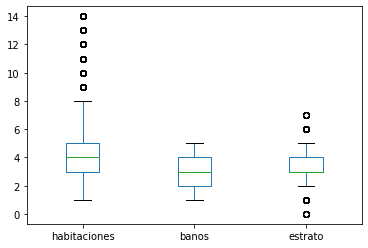

In [21]:
prueba[['habitaciones', 'banos', 'estrato']].plot(kind = 'box')

In [22]:
prueba['y'] = prueba['valorventa']/prueba['area']

In [23]:
prueba.groupby('data', as_index=False).id.count()

,data,id
0,test,53
1,train,40678


In [24]:
prueba = prueba[prueba['y']<prueba['y'].quantile(0.99).astype('int64')]

<AxesSubplot:title={'center':'y'}, xlabel='[estrato, habitaciones]'>

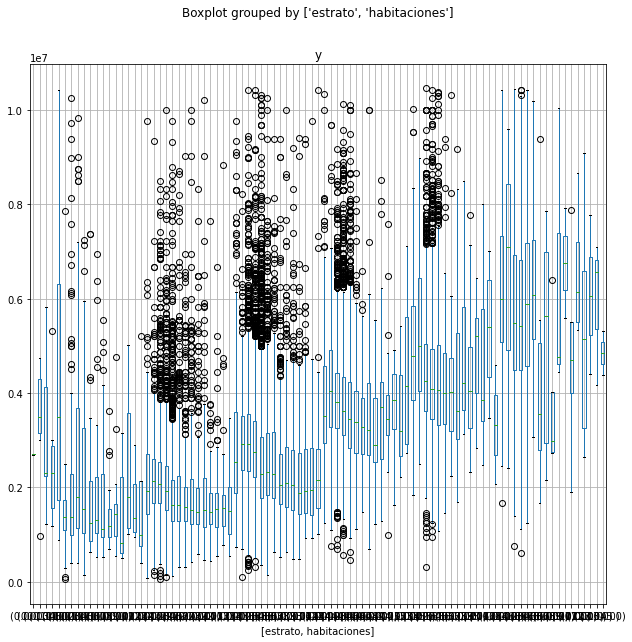

In [25]:
prueba[["y","estrato", "habitaciones"]].boxplot(by=["estrato", "habitaciones"], figsize=(10,10))

In [26]:
import geopandas

In [27]:
localidades_path = r'C:\Users\William\Desktop\el algoritmo es correcto\Datos abiertos bogota\localidades.json'
localidades = geopandas.read_file(localidades_path, crs={'init':'epsg:4686'})

In [28]:
estratificacion_path = r'C:\Users\William\Desktop\el algoritmo es correcto\Datos abiertos bogota\manzana_estratificacion.json'
estratificacion = geopandas.read_file(estratificacion_path, crs={'init':'epsg:4686'})

In [29]:
estratificacion = estratificacion[['ESTRATO', 'geometry']]

In [30]:
casas = geopandas.GeoDataFrame(
    prueba, geometry=geopandas.points_from_xy(prueba.longitud, prueba.latitud), crs={'init': 'epsg:4326'})

C:\Users\William\AppData\Local\Programs\Python\Python37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [31]:
avaluo_path = r'C:\Users\William\Desktop\el algoritmo es correcto\Datos abiertos bogota\avaluo'
avaluo = geopandas.read_file(avaluo_path, crs={'init':'epsg:4686'})

In [32]:
avaluo = avaluo[['CP_TERR_AR', 'GRUPOP_TER', 'AVALUO_COM', 'AVALUO_CAT', 'geometry']]

In [39]:
avaluo = avaluo[
    (avaluo['AVALUO_CAT']<avaluo['AVALUO_CAT'].quantile(0.99)) &
    (avaluo['AVALUO_CAT']>avaluo['AVALUO_CAT'].quantile(0.01)) &
    (avaluo['AVALUO_COM']<avaluo['AVALUO_COM'].quantile(0.99)) &
    (avaluo['AVALUO_COM']>avaluo['AVALUO_COM'].quantile(0.01))
]

In [40]:
pd.concat(
    [avaluo[['AVALUO_CAT', 'AVALUO_COM']].quantile(np.linspace(0,1,21)).astype('int64'),
    casas[['y']].quantile(np.linspace(0,1,21)).astype('int64')],
    axis=1)

,AVALUO_CAT,AVALUO_COM,y
0.00,4810,6800,55423
0.05,163667,216000,1196581
0.10,275787,386018,1448567
0.15,357500,495000,1652875
0.20,428356,600000,1833333
0.25,519393,690000,2031250
0.30,595730,810483,2222222
0.35,690459,950000,2400000
0.40,813656,1110022,2592592
0.45,919723,1300000,2780713


In [47]:
interseccion1 = geopandas.sjoin(left_df=casas, right_df=estratificacion, how='left', op='intersects').drop(columns=['index_right'])

ipykernel_launcher:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326



In [48]:
interseccion1.columns

Index(['id', 'area', 'balcon', 'banos', 'banoservicio', 'cuartoservicio',
       'deposito', 'estrato', 'estudio', 'garajes', 'habitaciones',
       'halldealcobas', 'parqueaderovisitantes', 'piso', 'remodelado',
       'saloncomunal', 'terraza', 'tiempodeconstruido', 'vigilancia', 'vista',
       'zonalavanderia', 'valorventa', 'latitud', 'longitud', 'data', 'y',
       'geometry', 'ESTRATO'],
      dtype='object')

In [49]:
interseccion2 = geopandas.sjoin(left_df=interseccion1, right_df=avaluo, how='left', op='intersects').drop(columns=['index_right'])

ipykernel_launcher:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326



In [50]:
interseccion2.columns

Index(['id', 'area', 'balcon', 'banos', 'banoservicio', 'cuartoservicio',
       'deposito', 'estrato', 'estudio', 'garajes', 'habitaciones',
       'halldealcobas', 'parqueaderovisitantes', 'piso', 'remodelado',
       'saloncomunal', 'terraza', 'tiempodeconstruido', 'vigilancia', 'vista',
       'zonalavanderia', 'valorventa', 'latitud', 'longitud', 'data', 'y',
       'geometry', 'ESTRATO', 'CP_TERR_AR', 'GRUPOP_TER', 'AVALUO_COM',
       'AVALUO_CAT'],
      dtype='object')

In [54]:
columnas_rellenar = ['CP_TERR_AR', 'GRUPOP_TER']
interseccion2[columnas_rellenar] = interseccion2[columnas_rellenar].fillna('No define')

In [55]:
interseccion2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 40320 entries, 0 to 244540
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     40320 non-null  int64   
 1   area                   40320 non-null  float64 
 2   balcon                 40320 non-null  float64 
 3   banos                  40320 non-null  float64 
 4   banoservicio           40320 non-null  float64 
 5   cuartoservicio         40320 non-null  float64 
 6   deposito               40320 non-null  object  
 7   estrato                38854 non-null  float64 
 8   estudio                40320 non-null  float64 
 9   garajes                40320 non-null  object  
 10  habitaciones           40320 non-null  float64 
 11  halldealcobas          40320 non-null  float64 
 12  parqueaderovisitantes  40320 non-null  float64 
 13  piso                   40320 non-null  object  
 14  remodelado             40320 

In [56]:
interseccion2['ESTRATO'] = np.where(
    interseccion2['ESTRATO'].isna() | interseccion2['ESTRATO']==0,
    np.NaN,
    interseccion2['ESTRATO']
)

In [88]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [61]:
train = interseccion2.loc[interseccion2['ESTRATO'].notna(),['ESTRATO', 'latitud', 'longitud']]
X = train[['latitud', 'longitud']].values
y = train[['ESTRATO']].values
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=3, metric = 'euclidean')
neigh.fit(X_train, y_train.ravel())
y_pred = neigh.predict(X_test)
print("R^2: {}".format(neigh.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

R^2: 0.961941008563273
Root Mean Squared Error: 0.2750313536317174
Accuracy: 0.961941008563273


In [63]:
valores = interseccion2.loc[interseccion2['ESTRATO'].isnull(),['latitud', 'longitud']].values
interseccion2.loc[interseccion2['ESTRATO'].isnull(),'ESTRATO'] = neigh.predict(valores)

In [68]:
train = interseccion2.loc[interseccion2['AVALUO_COM'].notna(),['AVALUO_COM', 'latitud', 'longitud']]
X = train[['latitud', 'longitud']].values
y = train[['AVALUO_COM']].values
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
neigh = KNeighborsRegressor(algorithm='brute', n_neighbors=5,  leaf_size=1, p=2, weights='distance', metric='chebyshev', n_jobs=-1)
neigh.fit(X_train, y_train.ravel())
y_pred = neigh.predict(X_test)
print("R^2: {}".format(neigh.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.7174077600672832
Root Mean Squared Error: 514254.21551415895


In [69]:
valores = interseccion2.loc[interseccion2['AVALUO_COM'].isnull(),['latitud', 'longitud']].values
interseccion2.loc[interseccion2['AVALUO_COM'].isnull(),'AVALUO_COM'] = neigh.predict(valores)

In [70]:
train = interseccion2.loc[interseccion2['AVALUO_CAT'].notna(),['AVALUO_CAT', 'latitud', 'longitud']]
X = train[['latitud', 'longitud']].values
y = train[['AVALUO_CAT']].values
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
neigh = KNeighborsRegressor(algorithm='brute', n_neighbors=5,  leaf_size=1, p=2, weights='distance', metric='chebyshev', n_jobs=-1)
neigh.fit(X_train, y_train.ravel())
y_pred = neigh.predict(X_test)
print("R^2: {}".format(neigh.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.7701890967816573
Root Mean Squared Error: 350285.0238500061


In [71]:
valores = interseccion2.loc[interseccion2['AVALUO_CAT'].isnull(),['latitud', 'longitud']].values
interseccion2.loc[interseccion2['AVALUO_CAT'].isnull(),'AVALUO_CAT'] = neigh.predict(valores)

In [72]:
interseccion2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 40320 entries, 0 to 244540
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     40320 non-null  int64   
 1   area                   40320 non-null  float64 
 2   balcon                 40320 non-null  float64 
 3   banos                  40320 non-null  float64 
 4   banoservicio           40320 non-null  float64 
 5   cuartoservicio         40320 non-null  float64 
 6   deposito               40320 non-null  object  
 7   estrato                38854 non-null  float64 
 8   estudio                40320 non-null  float64 
 9   garajes                40320 non-null  object  
 10  habitaciones           40320 non-null  float64 
 11  halldealcobas          40320 non-null  float64 
 12  parqueaderovisitantes  40320 non-null  float64 
 13  piso                   40320 non-null  object  
 14  remodelado             40320 

In [73]:
interseccion2.groupby(['ESTRATO'], as_index=False, dropna=False).agg(**{'Cantidad': pd.NamedAgg('latitud','count')})

,ESTRATO,Cantidad
0,1.0,811
1,2.0,7868
2,3.0,14475
3,4.0,8811
4,5.0,5653
5,6.0,2702


In [75]:
a = interseccion2['estrato'] - interseccion2['ESTRATO']
pd.DataFrame(a, columns=['Dif Estrato']).reset_index(drop=False).rename(columns={'index':'Cantidad'}).groupby('Dif Estrato', as_index=False, dropna=False).count()

,Dif Estrato,Cantidad
0,-6.0,2
1,-5.0,29
2,-4.0,65
3,-3.0,354
4,-2.0,923
5,-1.0,2943
6,0.0,30254
7,1.0,3375
8,2.0,582
9,3.0,201


In [76]:
interseccion2 = interseccion2.set_index('id')

In [77]:
interseccion2.columns

Index(['area', 'balcon', 'banos', 'banoservicio', 'cuartoservicio', 'deposito',
       'estrato', 'estudio', 'garajes', 'habitaciones', 'halldealcobas',
       'parqueaderovisitantes', 'piso', 'remodelado', 'saloncomunal',
       'terraza', 'tiempodeconstruido', 'vigilancia', 'vista',
       'zonalavanderia', 'valorventa', 'latitud', 'longitud', 'data', 'y',
       'geometry', 'ESTRATO', 'CP_TERR_AR', 'GRUPOP_TER', 'AVALUO_COM',
       'AVALUO_CAT'],
      dtype='object')

In [79]:
eliminar_columnas = ['estrato', 'geometry', 'latitud', 'longitud']
interseccion2 = interseccion2.drop(columns=eliminar_columnas)

<AxesSubplot:title={'center':'y'}, xlabel='[ESTRATO, habitaciones]'>

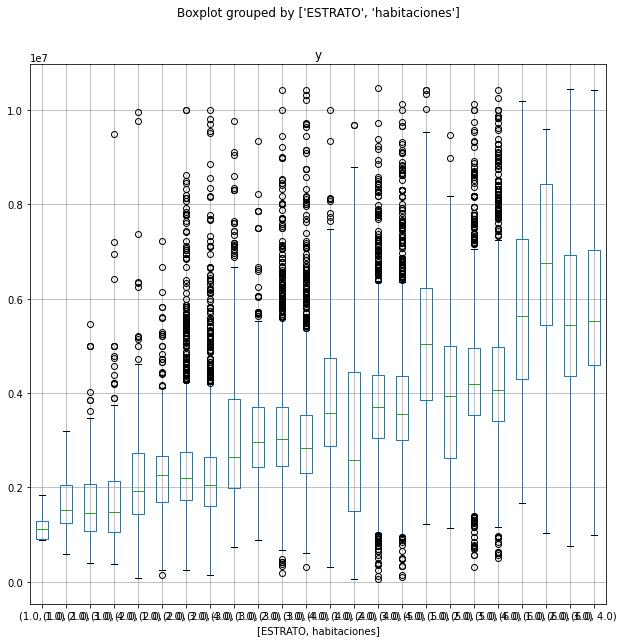

In [80]:
interseccion2.loc[interseccion2["habitaciones"]<5,["y","ESTRATO", "habitaciones"]].boxplot(by=["ESTRATO", "habitaciones"], figsize=(10,10))

In [203]:
columnas_dummy = [
    'deposito', 'garajes', 'piso', 'tiempodeconstruido', 
    'vigilancia',  'vista', 'zonalavanderia', 'GRUPOP_TER', 'CP_TERR_AR' ]
data1 = pd.get_dummies(interseccion2.drop(columns=['AVALUO_COM','AVALUO_CAT']), drop_first=True, columns=columnas_dummy)

In [204]:
data1.columns

Index(['area', 'balcon', 'banos', 'banoservicio', 'cuartoservicio', 'estudio',
       'habitaciones', 'halldealcobas', 'parqueaderovisitantes', 'remodelado',
       'saloncomunal', 'terraza', 'valorventa', 'data', 'y', 'ESTRATO',
       'deposito_No define', 'deposito_Si', 'garajes_1.0', 'garajes_2.0',
       'garajes_3.0', 'garajes_4.0', 'garajes_5', 'garajes_No define',
       'piso_2.0', 'piso_3.0', 'piso_4.0', 'piso_No define',
       'tiempodeconstruido_16 a 30 años', 'tiempodeconstruido_9 a 15 años',
       'tiempodeconstruido_Entre 0 y 5 años',
       'tiempodeconstruido_Entre 10 y 20 años',
       'tiempodeconstruido_Entre 5 y 10 años',
       'tiempodeconstruido_Menos de 1 año',
       'tiempodeconstruido_Más de 20 años',
       'tiempodeconstruido_Más de 30 años', 'tiempodeconstruido_No define',
       'tiempodeconstruido_Remodelado', 'vigilancia_1.0',
       'vigilancia_No define', 'vista_Interior', 'vista_No defina',
       'zonalavanderia_No define',
       'GRUPOP_TER_CLI

In [205]:
data_test = data1[data1['data']=='test'].drop(columns=['data'])
data1 = data1[data1['data']=='train'].drop(columns=['data'])

In [206]:
X = data1.drop(columns=['y']).values
y = data1[['y']].values

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [207]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(data_test.shape)

(36240, 53)
(4027, 53)
(36240, 1)
(4027, 1)
(53, 54)


In [208]:
mod = DecisionTreeRegressor(
    criterion='friedman_mse',  
    splitter='best', 
    max_depth=70, #None
    min_samples_split=2, 
    min_weight_fraction_leaf=0.0, 
    max_leaf_nodes=None,
    max_features='auto', #None
    min_impurity_decrease=0,
    random_state=0
).fit(X_train, y_train)

In [209]:
mean_absolute_percentage_error(y_train, mod.predict(X_train))

7.453345045192276e-12

In [210]:
mean_absolute_percentage_error(y_test, mod.predict(X_test))*1000

8.267462812826242

In [211]:
mean_absolute_percentage_error(
    data_test[['y']].values,
    mod.predict(data_test.drop(columns=['y']).values))*1000

2.2276975299287596

In [212]:
resultados = mod.predict(data_test.drop(columns=['y']).values)

In [213]:
resultados_df = pd.DataFrame(resultados, index=data_test.index, columns=['valormt2_predicted'])\
    .reset_index(drop=False).rename(columns={'index':'id'})

In [214]:
resultados_df.to_csv(r'C:\Users\William\Desktop\el algoritmo es correcto\resultado2.csv', index=False)

## Modelo 2

In [ ]:
from sklearn.pipeline import Pipeline

X = data1.drop(columns=['y']).values
y = data1[['y']].values

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [ ]:
mod2 = DecisionTreeRegressor(criterion='mae',random_state=0).fit(X_train, y_train)

In [ ]:
mean_absolute_percentage_error(y_test, mod2.predict(X_test))*1000

In [ ]:
mean_absolute_percentage_error(
    data_test[['y']].values,
    mod2.predict(data_test.drop(columns=['y']).values))*1000

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV 
dtr = DecisionTreeRegressor()

# Specify the hyperparameter space
parameters = {'criterion':['mse', 'friedman_mse', 'mae'],
              'max_depth': np.append(np.arange(0, 15, 2),np.array([None])),
              'splitter':['random', 'best']#,
            #   'max_features': np.append(np.arange(0, 15, 2),np.array([None, 'auto', 'sqrt', 'log2']))
              }
#Cambiar a gridsearch 
cv = GridSearchCV (
    dtr, 
    parameters, 
    # scoring='neg_mean_absolute_percentage_error', 
    cv = 2, 
    n_jobs=6
)

In [ ]:
cv.fit(X_train, y_train)

In [ ]:
cv.best_params_

In [ ]:
mod3 = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, random_state=0).fit(X_train, y_train)
print(mean_absolute_percentage_error(y_test, mod3.predict(X_test))*1000)
print(mean_absolute_percentage_error(data_test[['y']].values, mod3.predict(data_test.drop(columns=['y']).values))*1000)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

In [ ]:

parameters = {'criterion':['friedman_mse'],
              'splitter':['best'],
              'max_depth': np.array([70, None]),
              'min_samples_split': [2],
              'min_weight_fraction_leaf': [0],
              'max_features': np.array(['auto', None]),
              'max_leaf_nodes': [None],
              'min_impurity_decrease': [0],
              'min_impurity_split': np.linspace(0,10,11),
              'ccp_alpha': np.linspace(0,10,11)
              }
#Cambiar a GridSearch 
cv2 = GridSearchCV(
  dtr, 
  parameters, 
  # scoring=make_scorer(mean_absolute_percentage_error), 
  cv = 3, 
  n_jobs=-1
)

In [ ]:
cv2.fit(X_train, y_train)

In [ ]:
cv2.best_params_

In [ ]:
mod4 = DecisionTreeRegressor(
    criterion='friedman_mse', 
    splitter='best',
    max_depth=70, #70
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    max_features='auto', #None
    min_impurity_decrease=0,
    random_state=0).fit(X_train, y_train) #'friedman_mse'

In [ ]:
mean_absolute_percentage_error(y_train, mod4.predict(X_train))*1000

In [ ]:
mean_absolute_percentage_error(y_test, mod4.predict(X_test))*1000

In [ ]:
mean_absolute_percentage_error(
    data_test[['y']].values,
    mod4.predict(data_test.drop(columns=['y']).values))*1000